In [3]:
! rm -rf data/titanic
! rm -rf data/titanic.zip
! pip install kaggle
! kaggle competitions download -c titanic -p data/
! unzip data/titanic.zip -d data/titanic

  0%|                                               | 0.00/34.1k [00:00<?, ?B/s]
100%|███████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 354kB/s]
Archive:  data/titanic.zip
  inflating: data/titanic/gender_submission.csv  
  inflating: data/titanic/test.csv   
  inflating: data/titanic/train.csv  


In [4]:
import tensorflow as tf
import numpy as np
from scipy.special import logit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

def mapIsAlone(x):
  if(x > 1):
    return 0
  else:
    return 1

In [5]:
train_set = pd.read_csv("data/titanic/train.csv",sep=",", encoding="ISO-8859-1", low_memory=False,)
test_set = pd.read_csv("data/titanic/test.csv",sep=",", encoding="ISO-8859-1", low_memory=False,)
# Substituir os valores nulos
train_set["Age"].fillna(train_set["Age"].median(), inplace = True)
test_set["Age"].fillna(test_set["Age"].median(), inplace = True)
test_set["Fare"].fillna(test_set["Fare"].median(), inplace = True)
Embarked_mode=train_set['Embarked'].mode()[0]
train_set["Embarked"].fillna("S", inplace = True)
# Eliminar colunas desnecessarias
train_set.drop("Cabin", axis = 1, inplace = True)
test_set.drop("Cabin", axis = 1, inplace = True)
train_set.drop(["Name","Ticket"], axis = 1, inplace = True)
test_set.drop(["Name","Ticket"], axis = 1, inplace = True)

# Categorizar numericamente
train_set['Sex'] = train_set['Sex'].map({'female': 0, 'male': 1})
test_set['Sex']= test_set['Sex'].map({'female': 0, 'male': 1})
train_set['Embarked'] = train_set['Embarked'].map({'S': 0, 'C': 1,'Q': 2})
test_set['Embarked']= test_set['Embarked'].map({'S': 0, 'C': 1,'Q': 2})
# Eliminas redundâncias
train_set["Family"] = train_set["SibSp"] + train_set["Parch"] + 1
test_set["Family"] = test_set["SibSp"] + test_set["Parch"] + 1
train_set["IsAlone"] = train_set["Family"].map(mapIsAlone)
test_set["IsAlone"] = test_set["Family"].map(mapIsAlone)

train_set=train_set.drop(["Family"],axis=1)
test_set=test_set.drop(["Family"],axis=1)
train_set=train_set.drop(["SibSp","Parch"],axis=1)
test_set=test_set.drop(["SibSp","Parch"],axis=1)

scaler = StandardScaler()
train_set[['Age','Fare']] = scaler.fit_transform(train_set[['Age','Fare']])
test_set[['Age','Fare']] = scaler.transform(test_set[['Age','Fare']])

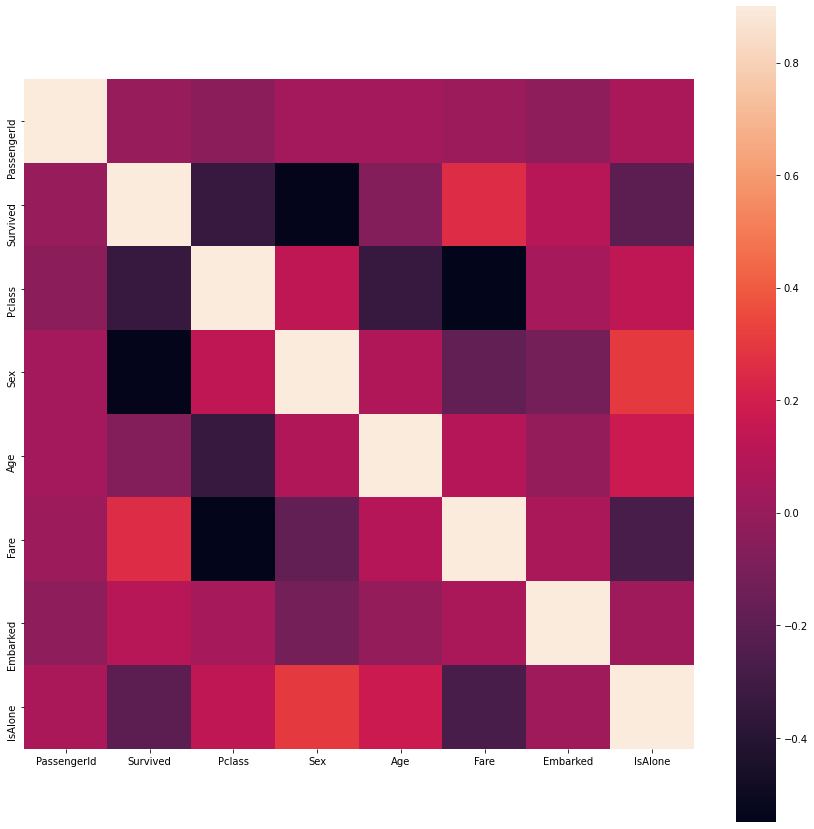

In [6]:
corr = train_set.corr()

plt.figure(figsize=(15,15))

sns.heatmap(corr,vmax=0.9,square=True)
plt.show()

In [7]:
train_set.isnull().mean()

PassengerId    0.0
Survived       0.0
Pclass         0.0
Sex            0.0
Age            0.0
Fare           0.0
Embarked       0.0
IsAlone        0.0
dtype: float64

In [8]:
test_set.isnull().mean()

PassengerId    0.0
Pclass         0.0
Sex            0.0
Age            0.0
Fare           0.0
Embarked       0.0
IsAlone        0.0
dtype: float64

In [9]:
train_set.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,1,0,3,1,-0.565736,-0.502445,0,0
1,2,1,1,0,0.663861,0.786845,1,0
2,3,1,3,0,-0.258337,-0.488854,0,1
3,4,1,1,0,0.433312,0.420730,0,0
4,5,0,3,1,0.433312,-0.486337,0,1


In [10]:
train_set[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [11]:
X_train = train_set.drop(['Survived','PassengerId'], axis=1)
y_train = train_set["Survived"]
X_test  = test_set.drop("PassengerId", axis=1)

In [12]:
X_train.head()

,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,3,1,-0.565736,-0.502445,0,0
1,1,0,0.663861,0.786845,1,0
2,3,0,-0.258337,-0.488854,0,1
3,1,0,0.433312,0.420730,0,0
4,3,1,0.433312,-0.486337,0,1


In [13]:
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [14]:
X_test.head()

,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,3,1,0.394887,-0.490783,2,1
1,3,0,1.355510,-0.507479,0,0
2,2,1,2.508257,-0.453367,2,1
3,3,1,-0.181487,-0.474005,0,1
4,3,0,-0.565736,-0.401017,0,0


In [15]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>=0.9):
          self.model.stop_training = True

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(None,6)),
  tf.keras.layers.Dense(512,activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(1024,activation=tf.keras.activations.relu),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(512,activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)

])
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=300, callbacks=[myCallback()])

Epoch 1/300
28/28 [==============================] - 0s 5ms/step - loss: 0.5476 - accuracy: 0.7138
Epoch 2/300
28/28 [==============================] - 0s 5ms/step - loss: 0.4901 - accuracy: 0.7845
Epoch 3/300
28/28 [==============================] - 0s 5ms/step - loss: 0.4776 - accuracy: 0.7935
Epoch 4/300
28/28 [==============================] - 0s 5ms/step - loss: 0.4788 - accuracy: 0.7957
Epoch 5/300
28/28 [==============================] - 0s 6ms/step - loss: 0.4432 - accuracy: 0.8126
Epoch 6/300
28/28 [==============================] - 0s 5ms/step - loss: 0.4464 - accuracy: 0.8047
Epoch 7/300
28/28 [==============================] - 0s 5ms/step - loss: 0.4273 - accuracy: 0.8171
Epoch 8/300
28/28 [==============================] - 0s 5ms/step - loss: 0.4210 - accuracy: 0.8238
Epoch 9/300
28/28 [==============================] - 0s 5ms/step - loss: 0.4242 - accuracy: 0.8193
Epoch 10/300
28/28 [==============================] - 0s 5ms/step - loss: 0.4148 - accuracy: 0.8283
Epoch 11/

In [16]:
test_predictions = model.predict(X_test)

test_predictions

array([[7.09193945e-03],
       [4.97074798e-05],
       [5.34949111e-16],
       [8.75259042e-02],
       [4.36198771e-01],
       [1.57514453e-01],
       [2.57197291e-01],
       [1.11523569e-02],
       [3.21320951e-01],
       [6.85010036e-07],
       [9.21455324e-02],
       [5.70530713e-01],
       [1.00000000e+00],
       [2.16802647e-07],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.84232613e-05],
       [3.75089765e-01],
       [1.44762874e-01],
       [6.02483749e-04],
       [3.72505605e-01],
       [9.98406053e-01],
       [1.00000000e+00],
       [9.99999344e-01],
       [1.00000000e+00],
       [3.54554186e-09],
       [1.00000000e+00],
       [2.25838959e-01],
       [9.28181469e-01],
       [2.97363460e-01],
       [4.52401849e-07],
       [7.52955675e-04],
       [8.90103340e-01],
       [2.20260024e-03],
       [8.73474300e-01],
       [4.87170815e-01],
       [4.04779673e-01],
       [5.72845280e-01],
       [5.58122396e-02],
       [5.95671475e-01],
